In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import os

import time
from math import *

from matplotlib.colors import LogNorm
import matplotlib.dates as mdates
import dateutil.tz as tz
local_tz = tz.gettz("Asia/Manila")

In [2]:
file_str = '/Users/svisaga/OneDrive - UW-Madison/hsrl_cirrus_pbl_files/hsrl_data/ahsrl_20191002T2055_20191003T1155_60s_30m.nc'
DS_v1 = xr.open_dataset(file_str)

<xarray.Dataset>
Dimensions:                                (calibration: 2,
                                            calibration_altitude: 667,
                                            time: 651, mean_time: 651,
                                            raw_time: 1797, altitude: 667,
                                            bin_range: 3208, profile_time: 1)
Coordinates:
  * time                                   (time) datetime64[ns] 2019-10-02T2...
  * mean_time                              (mean_time) datetime64[ns] 2019-10...
  * raw_time                               (raw_time) datetime64[ns] 2019-10-...
  * altitude                               (altitude) float32 0.0 ... 1.998e+04
Dimensions without coordinates: calibration, calibration_altitude, bin_range,
                                profile_time
Data variables: (12/76)
    base_time                              datetime64[ns] ...
    sonde_times                            (calibration) datetime64[ns] ...
    new_cal_times                          (calibration) datetime64[ns] ...
    top_alt_sounding                       (calibration) float32 ...
    temperature_profile                    (calibration, calibration_altitude) float32 ...
    pressure_profile                       (calibration, calibration_altitude) float32 ...
    ...                                     ...
    profile_beta_a_backscat_parallel       (profile_time, altitude) float32 ...
    profile_beta_a_backscat_perpendicular  (profile_time, altitude) float32 ...
    profile_beta_a_backscat                (profile_time, altitude) float32 ...
    profile_Na                             (profile_time, altitude) float32 ...
    profile_Nm                             (profile_time, altitude) float32 ...
    profile_Ncp                            (profile_time, altitude) float32 ...
Attributes: (12/131)
    dpl_py_template:                                                         ...
    dpl_py_template_version:                                                 ...
    time_zone:                                                               ...
    codeversion:                                                             ...
    codedate:                                                                ...
    shellb3_distribution_version:                                            ...
    ...                                                                                   ...
    hsrl_processing_parameter__wfov_corr__time_filter_order:                 ...
    hsrl_processing_parameter__wfov_corr__correct_below_range:               ...
    hsrl_processing_parameter__wfov_corr__min_fit_range:                     ...
    hsrl_processing_parameter__wfov_corr__z_norm_interval:                   ...
    hsrl_processing_parameter__wfov_corr__enable_z_fit:                      ...
    hsrl_processing_parameter__alternate_cal_dir__full_dir_path:             ...

In [4]:
ba = DS_v1.beta_a_backscat

In [5]:
save_month = 10 
save_day = 3
add = 1

In [6]:
dd = ba.assign_coords(day = ba.time.dt.day.to_index()).day
hh = ba.assign_coords(hour = ba.time.dt.hour.to_index()).hour
ba_daytime = ba.where( ((dd == save_day-1) & (hh > 21)) | ((dd == save_day) & (hh < 9)),drop=True)
ba_daytime_2km = ba_daytime.sel(altitude=slice(100,2000))
ba_daytime_2km_T = ba_daytime_2km.transpose()

# Calculate the ML height.

In [7]:
ba_d2_ = ba_daytime_2km_T
var_summary = ba_d2_ * [0]

<xarray.DataArray 'beta_a_backscat' (altitude: 63, time: 586)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time      (time) datetime64[ns] 2019-10-02T22:00:00 ... 2019-10-03T07:45:00
  * altitude  (altitude) float32 120.0 150.0 180.0 ... 1.95e+03 1.98e+03
    day       (time) int64 2 2 2 2 2 2 2 2 2 2 2 2 2 ... 3 3 3 3 3 3 3 3 3 3 3 3
    hour      (time) int64 22 22 22 22 22 22 22 22 22 22 ... 7 7 7 7 7 7 7 7 7 7

In [8]:
#loop over all timesteps (1 minute resolution). calculating variance per height
for i in range(0,ba_d2_.shape[1]-1):   
    variances = np.nanvar(ba_d2_[:,i:i+4], axis=-1)    
    var_summary[:,i] = variances

#here we are creating a data array to store the index with the max. variance value
var_fin = var_summary[1,:] *[0]

for i in range(0,var_fin.shape[0]-1):   
    try:
        variances = np.nanargmax(var_summary[:,i], axis=0)
        #print(500+ (variances*30))
        var_fin[i] = float(100+ (variances*30))  
    except ValueError as e:
        print('error')
    
for i in range(add,var_fin.shape[0]-add):   
    var_fin[i] = np.nanmean(var_fin[i-add:i+add]) 

<xarray.DataArray 'beta_a_backscat' (altitude: 63, time: 586)>
array([[6.55918428e-15, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.33619866e-16, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.25522268e-15, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.21479348e-16, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.15350641e-16, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.01586273e-17, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2019-10-02T22:00:00 ... 2019-10-03T07:45:00
  * altitude  (altitude) float32 120.0 150.0 180.0 ... 1.95e+03 1.98e+03
    day       (time) int64 2 2 2 2 2 2 2 2 2 2 2 2

<xarray.DataArray 'beta_a_backscat' (altitude: 63, time: 586)>
array([[6.55918428e-15, 3.12348854e-14, 3.51109421e-14, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.33619866e-16, 5.58709973e-16, 4.05919549e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.25522268e-15, 1.12497940e-15, 1.56616148e-15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.21479348e-16, 2.53595285e-16, 5.71019003e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.15350641e-16, 1.50417275e-16, 1.24207032e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.01586273e-17, 2.36216737e-16, 1.50371297e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2019-10-02T22:00:00 ... 2019-10-03T07:45:00
  * altitude  (altitude) float32 120.0 150.0 180.0 ... 1.95e+03 1.98e+03
    day       (time) int64 2 2 2 2 2 2 2 2 2 2 2 2

<xarray.DataArray 'beta_a_backscat' (altitude: 63, time: 586)>
array([[6.55918428e-15, 3.12348854e-14, 3.51109421e-14, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.33619866e-16, 5.58709973e-16, 4.05919549e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.25522268e-15, 1.12497940e-15, 1.56616148e-15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.21479348e-16, 2.53595285e-16, 5.71019003e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.15350641e-16, 1.50417275e-16, 1.24207032e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.01586273e-17, 2.36216737e-16, 1.50371297e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2019-10-02T22:00:00 ... 2019-10-03T07:45:00
  * altitude  (altitude) float32 120.0 150.0 180.0 ... 1.95e+03 1.98e+03
    day       (time) int64 2 2 2 2 2 2 2 2 2 2 2 2

<xarray.DataArray 'beta_a_backscat' (altitude: 63, time: 586)>
array([[6.55918428e-15, 3.12348854e-14, 3.51109421e-14, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.33619866e-16, 5.58709973e-16, 4.05919549e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.25522268e-15, 1.12497940e-15, 1.56616148e-15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.21479348e-16, 2.53595285e-16, 5.71019003e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.15350641e-16, 1.50417275e-16, 1.24207032e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.01586273e-17, 2.36216737e-16, 1.50371297e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2019-10-02T22:00:00 ... 2019-10-03T07:45:00
  * altitude  (altitude) float32 120.0 150.0 180.0 ... 1.95e+03 1.98e+03
    day       (time) int64 2 2 2 2 2 2 2 2 2 2 2 2

<xarray.DataArray 'beta_a_backscat' (altitude: 63, time: 586)>
array([[6.55918428e-15, 3.12348854e-14, 3.51109421e-14, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.33619866e-16, 5.58709973e-16, 4.05919549e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.25522268e-15, 1.12497940e-15, 1.56616148e-15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.21479348e-16, 2.53595285e-16, 5.71019003e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.15350641e-16, 1.50417275e-16, 1.24207032e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.01586273e-17, 2.36216737e-16, 1.50371297e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2019-10-02T22:00:00 ... 2019-10-03T07:45:00
  * altitude  (altitude) float32 120.0 150.0 180.0 ... 1.95e+03 1.98e+03
    day       (time) int64 2 2 2 2 2 2 2 2 2 2 2 2

<xarray.DataArray 'beta_a_backscat' (altitude: 63, time: 586)>
array([[6.55918428e-15, 3.12348854e-14, 3.51109421e-14, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.33619866e-16, 5.58709973e-16, 4.05919549e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.25522268e-15, 1.12497940e-15, 1.56616148e-15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.21479348e-16, 2.53595285e-16, 5.71019003e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.15350641e-16, 1.50417275e-16, 1.24207032e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.01586273e-17, 2.36216737e-16, 1.50371297e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2019-10-02T22:00:00 ... 2019-10-03T07:45:00
  * altitude  (altitude) float32 120.0 150.0 180.0 ... 1.95e+03 1.98e+03
    day       (time) int64 2 2 2 2 2 2 2 2 2 2 2 2

# Recalculate ML height < 09 AM LT. 

In [12]:
# Convert target time to numpy datetime64
target_time = np.datetime64('2019-10-03T01:00:00')

# Find the index where time equals or exceeds 01:00 UTC
idx_01utc = np.where(ba_daytime.time >= target_time)[0][0]
print("Index of 01:00 UTC:", idx_01utc)

Index of 01:00 UTC: 180


In [13]:
#loop over all timesteps (1 minute resolution). calculating variance per height
for i in range(0,ba_d2_.shape[1]-1):   
    variances = np.nanvar(ba_d2_[:,i:i+4], axis=-1)    
    var_summary[:,i] = variances

var_fin = var_summary[1,:] *[0]

for i in range(0,var_fin.shape[0]-1):   
    try:
        if i < idx_01utc:
            var_summary_ = var_summary.sel(altitude=slice(100, 500))
            variances = np.nanargmax(var_summary_[:,i], axis=0)
            var_fin[i] = float(100+ (variances*30))  
        else:
            var_summary_ = var_summary
            variances = np.nanargmax(var_summary_[:,i], axis=0)
            var_fin[i] = float(100+ (variances*30)) 
    except ValueError as e:
        print('error')
    
        
for i in range(add,var_fin.shape[0]-add):   
    var_fin[i] = np.nanmean(var_fin[i-add:i+add]) 

<xarray.DataArray 'beta_a_backscat' (altitude: 63, time: 586)>
array([[6.55918428e-15, 3.12348854e-14, 3.51109421e-14, ...,
        1.27199930e-17, 1.83239696e-17, 0.00000000e+00],
       [2.33619866e-16, 5.58709973e-16, 4.05919549e-16, ...,
        2.84957638e-15, 5.17106838e-16, 0.00000000e+00],
       [2.25522268e-15, 1.12497940e-15, 1.56616148e-15, ...,
        1.01400017e-14, 2.22654892e-16, 0.00000000e+00],
       ...,
       [1.21479348e-16, 2.53595285e-16, 5.71019003e-16, ...,
        1.19950123e-14, 1.09508367e-14, 0.00000000e+00],
       [1.15350641e-16, 1.50417275e-16, 1.24207032e-16, ...,
        7.85949471e-14, 4.69399639e-14, 0.00000000e+00],
       [7.01586273e-17, 2.36216737e-16, 1.50371297e-16, ...,
        1.31941970e-13, 7.67078255e-14, 0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2019-10-02T22:00:00 ... 2019-10-03T07:45:00
  * altitude  (altitude) float32 120.0 150.0 180.0 ... 1.95e+03 1.98e+03
    day       (time) int64 2 2 2 2 2 2 2 2 2 2 2 2

<xarray.DataArray 'beta_a_backscat' (altitude: 63, time: 586)>
array([[6.55918428e-15, 3.12348854e-14, 3.51109421e-14, ...,
        1.27199930e-17, 1.83239696e-17, 0.00000000e+00],
       [2.33619866e-16, 5.58709973e-16, 4.05919549e-16, ...,
        2.84957638e-15, 5.17106838e-16, 0.00000000e+00],
       [2.25522268e-15, 1.12497940e-15, 1.56616148e-15, ...,
        1.01400017e-14, 2.22654892e-16, 0.00000000e+00],
       ...,
       [1.21479348e-16, 2.53595285e-16, 5.71019003e-16, ...,
        1.19950123e-14, 1.09508367e-14, 0.00000000e+00],
       [1.15350641e-16, 1.50417275e-16, 1.24207032e-16, ...,
        7.85949471e-14, 4.69399639e-14, 0.00000000e+00],
       [7.01586273e-17, 2.36216737e-16, 1.50371297e-16, ...,
        1.31941970e-13, 7.67078255e-14, 0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2019-10-02T22:00:00 ... 2019-10-03T07:45:00
  * altitude  (altitude) float32 120.0 150.0 180.0 ... 1.95e+03 1.98e+03
    day       (time) int64 2 2 2 2 2 2 2 2 2 2 2 2

<xarray.DataArray 'beta_a_backscat' (altitude: 63, time: 586)>
array([[6.55918428e-15, 3.12348854e-14, 3.51109421e-14, ...,
        1.27199930e-17, 1.83239696e-17, 0.00000000e+00],
       [2.33619866e-16, 5.58709973e-16, 4.05919549e-16, ...,
        2.84957638e-15, 5.17106838e-16, 0.00000000e+00],
       [2.25522268e-15, 1.12497940e-15, 1.56616148e-15, ...,
        1.01400017e-14, 2.22654892e-16, 0.00000000e+00],
       ...,
       [1.21479348e-16, 2.53595285e-16, 5.71019003e-16, ...,
        1.19950123e-14, 1.09508367e-14, 0.00000000e+00],
       [1.15350641e-16, 1.50417275e-16, 1.24207032e-16, ...,
        7.85949471e-14, 4.69399639e-14, 0.00000000e+00],
       [7.01586273e-17, 2.36216737e-16, 1.50371297e-16, ...,
        1.31941970e-13, 7.67078255e-14, 0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2019-10-02T22:00:00 ... 2019-10-03T07:45:00
  * altitude  (altitude) float32 120.0 150.0 180.0 ... 1.95e+03 1.98e+03
    day       (time) int64 2 2 2 2 2 2 2 2 2 2 2 2

<xarray.DataArray 'beta_a_backscat' (altitude: 63, time: 586)>
array([[6.55918428e-15, 3.12348854e-14, 3.51109421e-14, ...,
        1.27199930e-17, 1.83239696e-17, 0.00000000e+00],
       [2.33619866e-16, 5.58709973e-16, 4.05919549e-16, ...,
        2.84957638e-15, 5.17106838e-16, 0.00000000e+00],
       [2.25522268e-15, 1.12497940e-15, 1.56616148e-15, ...,
        1.01400017e-14, 2.22654892e-16, 0.00000000e+00],
       ...,
       [1.21479348e-16, 2.53595285e-16, 5.71019003e-16, ...,
        1.19950123e-14, 1.09508367e-14, 0.00000000e+00],
       [1.15350641e-16, 1.50417275e-16, 1.24207032e-16, ...,
        7.85949471e-14, 4.69399639e-14, 0.00000000e+00],
       [7.01586273e-17, 2.36216737e-16, 1.50371297e-16, ...,
        1.31941970e-13, 7.67078255e-14, 0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2019-10-02T22:00:00 ... 2019-10-03T07:45:00
  * altitude  (altitude) float32 120.0 150.0 180.0 ... 1.95e+03 1.98e+03
    day       (time) int64 2 2 2 2 2 2 2 2 2 2 2 2

<xarray.DataArray 'beta_a_backscat' (altitude: 63, time: 586)>
array([[6.55918428e-15, 3.12348854e-14, 3.51109421e-14, ...,
        1.27199930e-17, 1.83239696e-17, 0.00000000e+00],
       [2.33619866e-16, 5.58709973e-16, 4.05919549e-16, ...,
        2.84957638e-15, 5.17106838e-16, 0.00000000e+00],
       [2.25522268e-15, 1.12497940e-15, 1.56616148e-15, ...,
        1.01400017e-14, 2.22654892e-16, 0.00000000e+00],
       ...,
       [1.21479348e-16, 2.53595285e-16, 5.71019003e-16, ...,
        1.19950123e-14, 1.09508367e-14, 0.00000000e+00],
       [1.15350641e-16, 1.50417275e-16, 1.24207032e-16, ...,
        7.85949471e-14, 4.69399639e-14, 0.00000000e+00],
       [7.01586273e-17, 2.36216737e-16, 1.50371297e-16, ...,
        1.31941970e-13, 7.67078255e-14, 0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2019-10-02T22:00:00 ... 2019-10-03T07:45:00
  * altitude  (altitude) float32 120.0 150.0 180.0 ... 1.95e+03 1.98e+03
    day       (time) int64 2 2 2 2 2 2 2 2 2 2 2 2

<xarray.DataArray 'beta_a_backscat' (altitude: 63, time: 586)>
array([[6.55918428e-15, 3.12348854e-14, 3.51109421e-14, ...,
        1.27199930e-17, 1.83239696e-17, 0.00000000e+00],
       [2.33619866e-16, 5.58709973e-16, 4.05919549e-16, ...,
        2.84957638e-15, 5.17106838e-16, 0.00000000e+00],
       [2.25522268e-15, 1.12497940e-15, 1.56616148e-15, ...,
        1.01400017e-14, 2.22654892e-16, 0.00000000e+00],
       ...,
       [1.21479348e-16, 2.53595285e-16, 5.71019003e-16, ...,
        1.19950123e-14, 1.09508367e-14, 0.00000000e+00],
       [1.15350641e-16, 1.50417275e-16, 1.24207032e-16, ...,
        7.85949471e-14, 4.69399639e-14, 0.00000000e+00],
       [7.01586273e-17, 2.36216737e-16, 1.50371297e-16, ...,
        1.31941970e-13, 7.67078255e-14, 0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2019-10-02T22:00:00 ... 2019-10-03T07:45:00
  * altitude  (altitude) float32 120.0 150.0 180.0 ... 1.95e+03 1.98e+03
    day       (time) int64 2 2 2 2 2 2 2 2 2 2 2 2

<xarray.DataArray 'beta_a_backscat' (altitude: 63, time: 586)>
array([[6.55918428e-15, 3.12348854e-14, 3.51109421e-14, ...,
        1.27199930e-17, 1.83239696e-17, 0.00000000e+00],
       [2.33619866e-16, 5.58709973e-16, 4.05919549e-16, ...,
        2.84957638e-15, 5.17106838e-16, 0.00000000e+00],
       [2.25522268e-15, 1.12497940e-15, 1.56616148e-15, ...,
        1.01400017e-14, 2.22654892e-16, 0.00000000e+00],
       ...,
       [1.21479348e-16, 2.53595285e-16, 5.71019003e-16, ...,
        1.19950123e-14, 1.09508367e-14, 0.00000000e+00],
       [1.15350641e-16, 1.50417275e-16, 1.24207032e-16, ...,
        7.85949471e-14, 4.69399639e-14, 0.00000000e+00],
       [7.01586273e-17, 2.36216737e-16, 1.50371297e-16, ...,
        1.31941970e-13, 7.67078255e-14, 0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2019-10-02T22:00:00 ... 2019-10-03T07:45:00
  * altitude  (altitude) float32 120.0 150.0 180.0 ... 1.95e+03 1.98e+03
    day       (time) int64 2 2 2 2 2 2 2 2 2 2 2 2

<xarray.DataArray 'beta_a_backscat' (altitude: 63, time: 586)>
array([[6.55918428e-15, 3.12348854e-14, 3.51109421e-14, ...,
        1.27199930e-17, 1.83239696e-17, 0.00000000e+00],
       [2.33619866e-16, 5.58709973e-16, 4.05919549e-16, ...,
        2.84957638e-15, 5.17106838e-16, 0.00000000e+00],
       [2.25522268e-15, 1.12497940e-15, 1.56616148e-15, ...,
        1.01400017e-14, 2.22654892e-16, 0.00000000e+00],
       ...,
       [1.21479348e-16, 2.53595285e-16, 5.71019003e-16, ...,
        1.19950123e-14, 1.09508367e-14, 0.00000000e+00],
       [1.15350641e-16, 1.50417275e-16, 1.24207032e-16, ...,
        7.85949471e-14, 4.69399639e-14, 0.00000000e+00],
       [7.01586273e-17, 2.36216737e-16, 1.50371297e-16, ...,
        1.31941970e-13, 7.67078255e-14, 0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2019-10-02T22:00:00 ... 2019-10-03T07:45:00
  * altitude  (altitude) float32 120.0 150.0 180.0 ... 1.95e+03 1.98e+03
    day       (time) int64 2 2 2 2 2 2 2 2 2 2 2 2

<xarray.DataArray 'beta_a_backscat' (altitude: 63, time: 586)>
array([[6.55918428e-15, 3.12348854e-14, 3.51109421e-14, ...,
        1.27199930e-17, 1.83239696e-17, 0.00000000e+00],
       [2.33619866e-16, 5.58709973e-16, 4.05919549e-16, ...,
        2.84957638e-15, 5.17106838e-16, 0.00000000e+00],
       [2.25522268e-15, 1.12497940e-15, 1.56616148e-15, ...,
        1.01400017e-14, 2.22654892e-16, 0.00000000e+00],
       ...,
       [1.21479348e-16, 2.53595285e-16, 5.71019003e-16, ...,
        1.19950123e-14, 1.09508367e-14, 0.00000000e+00],
       [1.15350641e-16, 1.50417275e-16, 1.24207032e-16, ...,
        7.85949471e-14, 4.69399639e-14, 0.00000000e+00],
       [7.01586273e-17, 2.36216737e-16, 1.50371297e-16, ...,
        1.31941970e-13, 7.67078255e-14, 0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2019-10-02T22:00:00 ... 2019-10-03T07:45:00
  * altitude  (altitude) float32 120.0 150.0 180.0 ... 1.95e+03 1.98e+03
    day       (time) int64 2 2 2 2 2 2 2 2 2 2 2 2

<xarray.DataArray 'beta_a_backscat' (altitude: 63, time: 586)>
array([[6.55918428e-15, 3.12348854e-14, 3.51109421e-14, ...,
        1.27199930e-17, 1.83239696e-17, 0.00000000e+00],
       [2.33619866e-16, 5.58709973e-16, 4.05919549e-16, ...,
        2.84957638e-15, 5.17106838e-16, 0.00000000e+00],
       [2.25522268e-15, 1.12497940e-15, 1.56616148e-15, ...,
        1.01400017e-14, 2.22654892e-16, 0.00000000e+00],
       ...,
       [1.21479348e-16, 2.53595285e-16, 5.71019003e-16, ...,
        1.19950123e-14, 1.09508367e-14, 0.00000000e+00],
       [1.15350641e-16, 1.50417275e-16, 1.24207032e-16, ...,
        7.85949471e-14, 4.69399639e-14, 0.00000000e+00],
       [7.01586273e-17, 2.36216737e-16, 1.50371297e-16, ...,
        1.31941970e-13, 7.67078255e-14, 0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2019-10-02T22:00:00 ... 2019-10-03T07:45:00
  * altitude  (altitude) float32 120.0 150.0 180.0 ... 1.95e+03 1.98e+03
    day       (time) int64 2 2 2 2 2 2 2 2 2 2 2 2

<xarray.DataArray 'beta_a_backscat' (altitude: 63, time: 586)>
array([[6.55918428e-15, 3.12348854e-14, 3.51109421e-14, ...,
        1.27199930e-17, 1.83239696e-17, 0.00000000e+00],
       [2.33619866e-16, 5.58709973e-16, 4.05919549e-16, ...,
        2.84957638e-15, 5.17106838e-16, 0.00000000e+00],
       [2.25522268e-15, 1.12497940e-15, 1.56616148e-15, ...,
        1.01400017e-14, 2.22654892e-16, 0.00000000e+00],
       ...,
       [1.21479348e-16, 2.53595285e-16, 5.71019003e-16, ...,
        1.19950123e-14, 1.09508367e-14, 0.00000000e+00],
       [1.15350641e-16, 1.50417275e-16, 1.24207032e-16, ...,
        7.85949471e-14, 4.69399639e-14, 0.00000000e+00],
       [7.01586273e-17, 2.36216737e-16, 1.50371297e-16, ...,
        1.31941970e-13, 7.67078255e-14, 0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2019-10-02T22:00:00 ... 2019-10-03T07:45:00
  * altitude  (altitude) float32 120.0 150.0 180.0 ... 1.95e+03 1.98e+03
    day       (time) int64 2 2 2 2 2 2 2 2 2 2 2 2

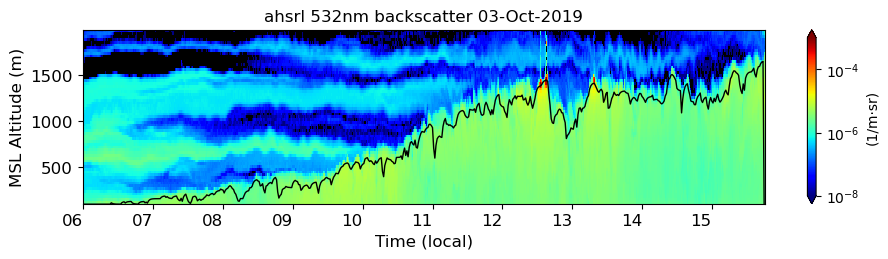

In [16]:
cmap = plt.cm.jet.copy()
cmap.set_bad(color='black')

fig, ax = plt.subplots(figsize=(11,3))
plt.minorticks_off()

# Plot with updated colormap
ba_daytime_2km_T.plot.pcolormesh(
    cmap=cmap,
    norm=LogNorm(vmin=1E-8, vmax=1E-3),
    cbar_kwargs={'label': '(1/m·sr)'}
)
plt.plot(var_fin.time,var_fin, linewidth = 1, color='black')

plt.xlabel('Time (local)', fontsize=12)
plt.ylabel('MSL Altitude (m)', fontsize=12)
plt.title(f"ahsrl 532nm backscatter 03-Oct-2019", fontsize=12)
plt.tick_params(labelsize=12)
plt.tick_params(axis='x', rotation=90)
plt.gcf().subplots_adjust(bottom=0.3)

myFmt = mdates.DateFormatter('%H', tz=local_tz)
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.setp(ax.get_xticklabels(), rotation=0, ha="right") 


output_filename = 'JGR_Paper_img/' + str(save_month) + '_' + str(save_day) + 'ahsrl_20191002T2055_20191003T1155_60s_30m.png'
plt.savefig(output_filename, dpi=300, bbox_inches='tight')